# Mesothelioma Mortality

We loosely replicate the empirical parts of [Martinez Miranda et al. (2015)](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/rssa.12051).

First, import the package

In [1]:
import apc

In [2]:
# Turn off FutureWarning from statsmodels
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Take a first look at the data

In [3]:
data = apc.asbestos()
data.head()

Age,25,26,27,28,29,30,31,32,33,34,...,85,86,87,88,89,90,91,92,93,94
Period,,,,,,,,,,,,,,,,,,,,,
1967,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1968,0,0,0,1,1,0,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0
1969,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,1,0,0,0
1970,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1971,0,0,0,1,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,0,0


Set up a model and attach the data to it.

In [4]:
model = apc.Model()
model.data_from_df(data)

Inferred 'data_format' from response: PA


Now we look at a first plot of the data. We plot the response over each of the three time-scales.

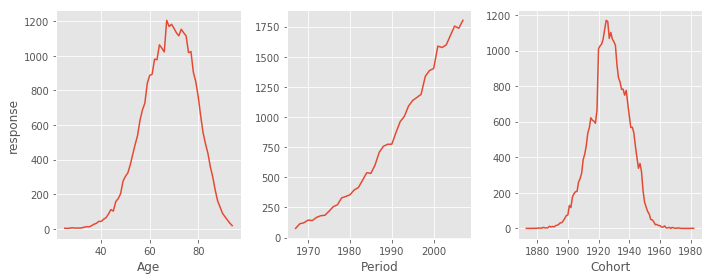

In [5]:
model.plot_data_sums(figsize=(10,4))

Martinez Miranda et al. (2015), drop age groups older than 89 due to sparsity. We redo the plot looking exclusively at data for these age groups.

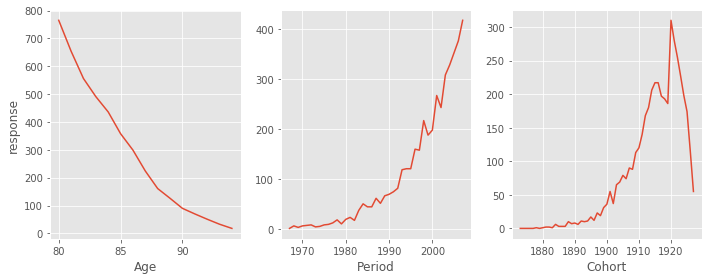

In [6]:
model.sub_model(age_from_to=(80,None)).plot_data_sums(figsize=(10,4))

We can see that there is indeed a sharp drop towards the end of the sample. Thus, we set up a sub-model that does not include these groups.

In [7]:
model = model.sub_model(age_from_to=(None, 89))

To confirm, we take a look at the data in vector form as organzied by ``data_from_df``:

In [8]:
model.data_vector.tail()

response
Age Period Cohort          
89  2003   1914          11
    2004   1915          13
    2005   1916           6
    2006   1917           8
    2007   1918          11

Success! The oldest age groups have been removed.

Next, we plot the data of one time-scale withint another.

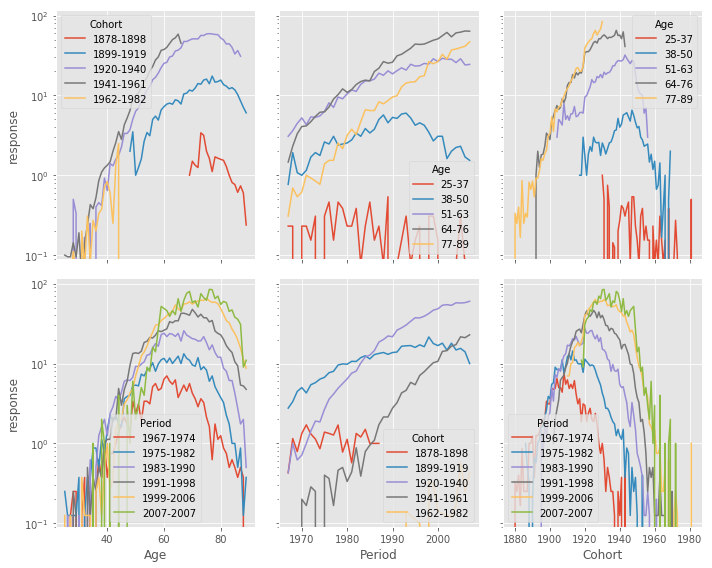

In [9]:
model.plot_data_within(figsize=(10,8), logy=True)

From the cohort within period plot (bottom middle), we can see that mortality seems to slowly taper off for the 1917-1938 cohorts while that for the 1939-1960 appears to still be rising.

Next, we fit a deviance table of a Poisson model to the data.

In [10]:
model.fit_table('poisson_response')
model.deviance_table

,deviance,df_resid,P>chi_sq,LR_vs_APC,df_vs_APC,P>chi_sq
APC,2384.92,2457,0.848235,NaN,NaN,NaN
AP,5336.03,2560,0,2951.11,103,0
AC,2441.73,2496,0.777661,56.8051,39,0.0325435
PC,8265.75,2520,0,5880.82,63,0
Ad,5912.42,2599,0,3527.5,142,0
Pd,23461.4,2623,0,21076.5,166,0
Cd,8494.66,2559,0,6109.73,102,0
A,21948,2600,0,19563.1,143,0
P,34391,2624,0,32006.1,167,0
C,28416,2560,0,26031.1,103,0


We see that an age-period-cohort model cannot be rejected with a p-value of 0.85 (against a saturated model with as many parameters as observations). The same holds for an age-cohort model with a p-value of 0.78. A reduction from an age-period-cohort to an age-cohort model yields a p-value of 0.03. Miranda et al. point out that it may still be acceptable to use this model since it eases forecasting substantially: it makes it unnecessary to extrapolate the period parameters into the future which would introduce another source of uncertainty. Further, simpler models often seem to be beneficial for forecasting.

*Remark: see [Nielsen (2014)](http://www.nuffield.ox.ac.uk/economics/papers/2014/apc_deviance.pdf) for an explanation of the individual predictors.*

We thus fit an age-cohort model to the data.

In [11]:
model.fit('poisson_response', 'AC')

We can now plot the parameters and their standard errors.

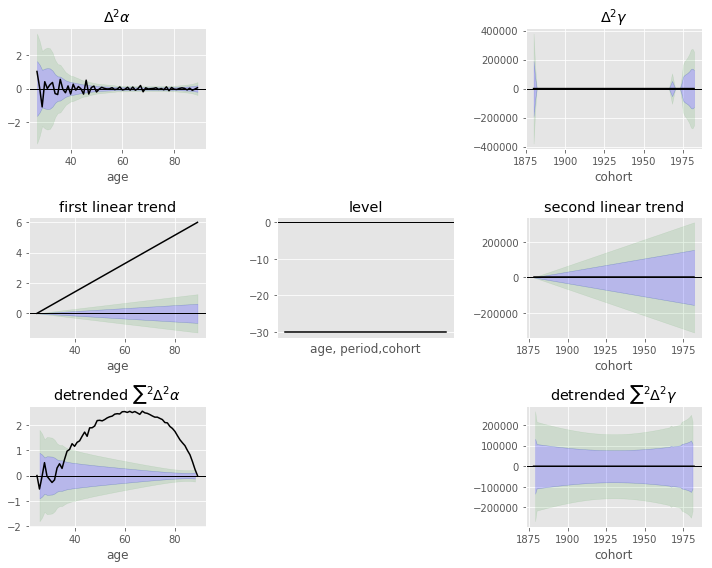

In [12]:
model.plot_fit(around_coef=False)

The level combined with the two linear trends specify a plane. The detrended double sums of double differences in the bottom row show deviations over and above this plane. To obtain the fitted value of the linear predictor for a given age and cohort, we add together the level, and the value of the linear trends and detrended double sums at the relevant age and cohort. The fitted value fo the response would be the exponential of this value. The detrended double sums start and end in zero by design. 

We can move on to look at a residual plot.

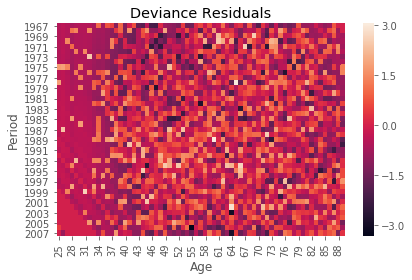

In [13]:
model.plot_residuals('deviance')

We would like this plot to look like white noise. While this looks quite reasonable for the upper age groups, the pattern appears somewhat different for the lower ages up to about 37. It seems that the fit there is generally somewhat better. From what we saw above, this may relate to the fact that the death counts for these age groups are quite low so that predicting something close to zero is going to give good results. Fitting these cells seems somewhat 'easier'.

Next, we move on to forecast from the model. The idea is to forecast mortality for future periods based on parameter estimates that are already available from the data. We can visualize that in a heatmap plot in age-cohort space.

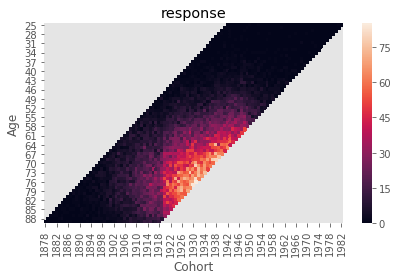

In [14]:
model.plot_data_heatmaps(space='AC')

Here, the idea is to fill in the empty values in the bottom right triangle. Estimates for age and cohort effects for these cells are already available. Since we do not have a period effect in the model, this is all we need.

We can now forecast from the model.

In [15]:
model.forecast()

This call generated (distribution) forecasts for individual cells, as well as aggregated by age, period and cohort. In the heatmap plot above, these correspond to row, column and (counter-)diagonal sums in the lower right triangle, respectively. Finally, a forecast for the total, that is the sum over all cells in the triangle, is available.

We find the peak in the point forecasts.

In [16]:
peak_year = model.forecasts['Period']['point_forecast'].idxmax()
print('Peak year is {}.'.format(peak_year))
model.forecasts['Period'].loc[peak_year-2:peak_year+2]

Peak year is 2019.


,point_forecast,se_total,se_process,se_estimation_xi2,q_0.75,q_0.9,q_0.95,q_0.99
Period,,,,,,,,
2017,2210.915927,57.760693,47.020378,33.546710,2249.874923,2284.939234,2305.923813,2345.287393
2018,2219.079693,59.335397,47.107109,36.077827,2259.100810,2295.121063,2316.677735,2357.114467
2019,2220.054343,60.842495,47.117453,38.493569,2261.091982,2298.027138,2320.131342,2361.595152
2020,2217.510124,62.653798,47.090446,41.327814,2259.769469,2297.804197,2320.566450,2363.264653
2021,2204.961179,64.121743,46.957014,43.665051,2248.210637,2287.136498,2310.432059,2354.130658


We can see that the generated arrays include not just the point forecast but also standard errors (broken down into process and estimation error) and quantile forecasts.

Next, we plot the forecasts aggregated by period.

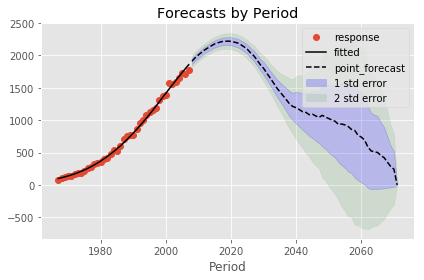

In [17]:
model.plot_forecast()

The plot includes one and two standard error bands. If we look closely, we can see that the fit seems to be somewhat worse for the last couple periods before the sample ends. One way to correct this is apply intercept correction. Martinez Miranda et al. (2015) suggest to multiply the point forecasts by the ratio of the last realiztion to the last fitted value.

In [18]:
final_realized = model.data_vector.sum(level='Period').sort_index().iloc[-1][0]
final_fitted = model.fitted_values.sum(level='Period').sort_index().iloc[-1]
print('Death counts for last period: {}'.format(final_realized))
print('Fitted value for last period: {:.2f}'.format(final_fitted))
print('Intercept correction factor: {:.2f}'.format(final_realized/final_fitted))

Death counts for last period: 1776
Fitted value for last period: 1855.50
Intercept correction factor: 0.96


We take a look at the plot with intercept correction, limiting our attention toe the period from 1990 to 2040.

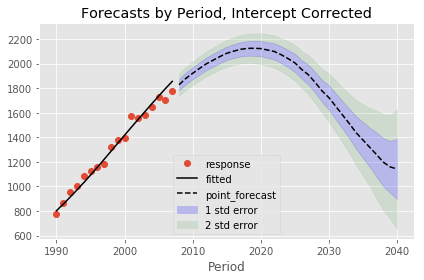

In [19]:
model.plot_forecast(ic=True, from_to=(1990,2040))

This plot does have a more natural appearance, lacking the jump at the end of the sample.

We can also look at forecasts over a different time scale, for example by age. In this case, we already have some data available for all age groups under consideration. We may then be more interested not just in the forecasts, but maybe in the sum of response and forecast.

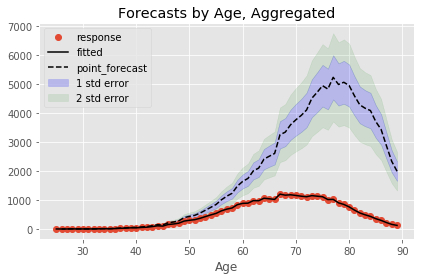

In [20]:
model.plot_forecast(by='Age', aggregate=True)

We can see that the forecast tells us to expect a shift in the mortality peak from age around 70 to the late 70s.

# References
* Martínez Miranda, M. D., Nielsen, B., & Nielsen, J. P. (2015). Inference and forecasting in the age-period-cohort model with unknown exposure with an application to mesothelioma mortality. *Journal of the Royal Statistical Society: Series A (Statistics in Society)*, 178(1), 29–55.
* Nielsen, B. (2014). Deviance analysis of age-period-cohort models. *Nuffield Discussion Paper*, (W03). [Download](http://www.nuffield.ox.ac.uk/economics/papers/2014/apc_deviance.pdf)